# Maps creation

In [30]:
import os
import fileinput

import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import shapely.wkt
from shapely.geometry import Point, Polygon
import pysal

import re

from scipy import stats

from branca.colormap import linear
import branca.colormap as colormap

import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime, TimeSliderChoropleth
from folium import IFrame

from IPython.display import display

%matplotlib inline

## Create basic event map with geopandas

Geopoandas provides us with a simple interface to visualize geographical data stored in pandas data structures

In [39]:
with open(os.path.join("pickle", 'conflict.pickle'), 'rb') as data_source:
    conflict_df = pickle.load(data_source)

In [40]:
geometry = conflict_df['geom_wkt'].map(shapely.wkt.loads)
conflict_df = conflict_df.drop('geom_wkt', axis=1)
crs = {'init': 'epsg:4326'}
conflict_gdf = gpd.GeoDataFrame(conflict_df, crs=crs, geometry=geometry)


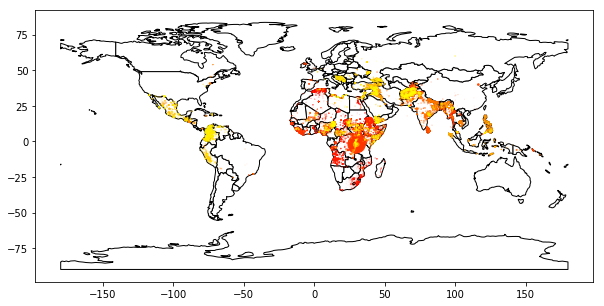

In [41]:
fig, ax = plt.subplots(figsize=(10,5))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


world.plot(ax=ax, color='white', edgecolor='black')
conflict_gdf.plot(ax=ax, markersize=(conflict_gdf.loc[:, "best"]/1000), cmap="autumn")
    
#plt.savefig('simple-conflicts-map.png')

## Create heatmap

### Generate the event_list dataframe

In [42]:
conflict_df.head(1)

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,country_id,region,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,geometry
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,678,Middle East,2010,2010,2,0,0,0,2,POINT (44.206667 15.354722)


In [43]:
event_list = conflict_df[["id", "latitude", "longitude", "deaths_civilians", "best", "year"]]
event_list.head(2)

,id,latitude,longitude,deaths_civilians,best,year
0,4,15.354722,44.206667,0,2,2010
1,5,12.779444,45.036667,0,0,2011


In [44]:
# keep only events w/ deaths
event_list = event_list[event_list.best > 0]

In [45]:
event_list = event_list.sort_values("year")

In [46]:
event_list.sort_values("best", ascending = False)
event_list.sort_values("best").head(5)

,id,latitude,longitude,deaths_civilians,best,year
51579,89995,19.461476,81.708160,0,1,2006
59365,99573,6.641599,101.446521,1,1,2005
786,1757,36.750000,3.666667,0,1,2005
59363,99571,6.543783,101.251049,1,1,2005
57926,98115,6.104253,101.893325,0,1,2005


### Create Heatmap with each events layered by year

In [47]:
event_df_array = []
for year in np.sort(event_list.year.unique()):
    print(year, end=", ") #make sure years are in the desired order
    event_df_array.append(event_list[event_list.year == year])

1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 

In [48]:
event_pos_date_array = []
for index in range(len(event_df_array)):
    event_pos_date_array.append([[row.latitude, row.longitude] for row in event_df_array[index].itertuples()])

In [49]:
m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=8)

index = 0
for index, year in enumerate(event_list.year.unique()):
    m.add_child(plugins.HeatMap(event_pos_date_array[index],
                                name="{}".format(year),
                                max_val=event_list.best.max(),
                                min_opacity=0.99,
                                radius=2,
                                blur=3,
                                max_zoom=10,
                                gradient ={0.01: 'black', 0.06: 'red', 0.20: 'orange', 0.3:'yellow', 0.5:'white',  1: 'magenta'},
                                overlay=True))


folium.LayerControl().add_to(m)
folium.plugins.Fullscreen().add_to(m)
m.save(os.path.join("results", 'heatmap_w_time_layered.html'))

### Create a timestamped heatmap

In [50]:
NBR_OF_BINS=1000
binned_deaths, bins = pd.qcut(event_list.best, q=NBR_OF_BINS, duplicates='drop', labels=False, retbins=True)
binned_deaths.name="bin_deaths"
# We add 1 to avoid bins at 0, because they would have null weight
binned_deaths += 1
binned_deaths_df = pd.DataFrame(binned_deaths )
print(len(bins))
display(binned_deaths_df.head(5))
# Avoid doing the merge multiple times
if "bin_deaths" not in event_list.columns:
    event_list = event_list.merge(binned_deaths_df,left_index=True, right_index=True )

74


,bin_deaths
12329,53
70619,1
8732,1
8726,1
8719,1


In [51]:
# NOT USEFULL SECTION FOR NOW! MIGHT BE USEFULL TO SHOW A LEGEND OR A BIN GRAPH
bin_df_cols = ["bin", "bin_range" , "nbr"]
heatmap_bins_df = pd.DataFrame([], columns=bin_df_cols).set_index(bin_df_cols[0])

for index, value in enumerate(bins):
    min_val = bins[index-1] if index is not 0 else 0
    max_val = bins[index]
    bin_range = (min_val, max_val)
    nbr =  len(event_list.loc[event_list.bin_deaths == (index+1)])
    temp_bin_df = pd.DataFrame([[index, bin_range, nbr]], columns=bin_df_cols)
    temp_bin_df = temp_bin_df.set_index(bin_df_cols[0])
    heatmap_bins_df = heatmap_bins_df.append(temp_bin_df)
heatmap_bins_df.head(5)

,bin_range,nbr
bin,,
0,"(0, 1.0)",58877
1,"(1.0, 2.0)",12805
2,"(2.0, 3.0)",8473
3,"(3.0, 4.0)",6419
4,"(4.0, 5.0)",4588


In [52]:
m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=8)

# We used bin dataset because it filters the extreme values, especially on the maximum size
# The norm isn't a 0 to 1 norm, it is a 1/bin_deaths.max() to 1, to force every event to be showed
column_to_use = "bin_deaths"
best_max = event_list[column_to_use].max()
best_min = event_list[column_to_use].min()
get_norm = lambda best: (best)/(best_max)



data_to_show = []
time_array = []
for year in event_list.year.unique():
    time_array.append(year)
    year_data = [[row.latitude, row.longitude, get_norm(row.bin_deaths)] for row in event_list.loc[event_list.year == year].itertuples()]
    data_to_show.append(year_data)
    
hm = plugins.HeatMapWithTime(data=data_to_show,
                             index=time_array,
                             name="deaths heatmap",
                             radius=7,
                             min_opacity=0.2,
                             max_opacity=1,
                             #scale_radius=True,
                             use_local_extrema=True,
                             display_index=True,
                             auto_play=True,
                             speed_step=0.1,
                             )
hm.add_to(m)

folium.plugins.Fullscreen().add_to(m)
m.save(os.path.join("results", 'heatmap_w_time.html'))

## Create maps with choroplets and events superposed using GeoPandas

### Create human cost GeoDataFrame

In [53]:
with open(os.path.join("pickle", 'country_human_cost.pickle'), 'rb') as data_source:
    country_human_cost_df = pickle.load(data_source)

In [54]:
display(country_human_cost_df.head(5))

number_of_events  \
year country_id                     
1989 41                         4   
     51                         1   
     70                         2   
     90                        78   
     92                        58   

                                                         events_id  \
year country_id                                                      
1989 41                           [186087, 186122, 186123, 186124]   
     51                                                   [107752]   
     70                                           [182047, 182048]   
     90          [193728, 193732, 193764, 193765, 193766, 19376...   
     92          [120534, 120536, 120537, 120538, 120539, 12054...   

                 displacement_extern  displacement_intern  total_displacement  \
year country_id                                                                 
1989 41                            0                    0                   0   
     51                            0                    0                   0   
     70                            0                    0                   0   
     90                            0                    0                   0   
     92                            0                    0                   0   

                 deaths  hdi country_code  
year country_id                            
1989 41              48  0.0          HTI  
     51               1  0.0          JAM  
     70               3  0.0          MEX  
     90             491  0.0          GTM  
     92            4924  0.0          SLV

In [55]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [56]:
world.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


In [57]:
indexed_world = world.set_index(["iso_a3"])
display(indexed_world.head(5))

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
AFG,28400000.0,Asia,Afghanistan,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
AGO,12799293.0,Africa,Angola,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
ALB,3639453.0,Europe,Albania,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
ARE,4798491.0,Asia,United Arab Emirates,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
ARG,40913584.0,South America,Argentina,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


In [58]:
geometry = pd.DataFrame([], columns=["year", "country_id", "geometry"])
for row in country_human_cost_df.itertuples():
    geometry_val = indexed_world.loc[row.country_code, "geometry"]
    temp_geo = pd.DataFrame([[row.Index[0], row.Index[1], geometry_val]], columns=["year", "country_id", "geometry"])
    geometry = pd.concat([geometry, temp_geo])
display(geometry.head(5))

,year,country_id,geometry
0,1989,41,POLYGON ((-73.18979061551762 19.91568390551191...
0,1989,51,POLYGON ((-77.56960079619921 18.49052541755049...
0,1989,70,"POLYGON ((-97.14000830767071 25.8699974634784,..."
0,1989,90,POLYGON ((-90.09555457229098 13.73533763270073...
0,1989,92,POLYGON ((-87.79311113152657 13.38448049565505...


In [59]:
geometry = geometry.set_index(["year", "country_id"])

In [60]:
crs = {'init': 'epsg:4326'}
human_cost_gdf = gpd.GeoDataFrame(country_human_cost_df, crs=crs, geometry=geometry.geometry.values)

In [61]:
display(human_cost_gdf.head(3))

number_of_events                         events_id  \
year country_id                                                       
1989 41                         4  [186087, 186122, 186123, 186124]   
     51                         1                          [107752]   
     70                         2                  [182047, 182048]   

                 displacement_extern  displacement_intern  total_displacement  \
year country_id                                                                 
1989 41                            0                    0                   0   
     51                            0                    0                   0   
     70                            0                    0                   0   

                 deaths  hdi country_code  \
year country_id                             
1989 41              48  0.0          HTI   
     51               1  0.0          JAM   
     70               3  0.0          MEX   

                                                          geometry  
year country_id                                                     
1989 41          POLYGON ((-73.18979061551762 19.91568390551191...  
     51          POLYGON ((-77.56960079619921 18.49052541755049...  
     70          POLYGON ((-97.14000830767071 25.8699974634784,...

In [62]:
display(conflict_gdf.head(3))

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,country_id,region,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,geometry
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,678,Middle East,2010,2010,2,0,0,0,2,POINT (44.206667 15.354722)
1,5,2011,3,715,Government of Yemen (North Yemen) - Civilians,123,678.0,Government of Yemen (North Yemen),NaN,1,...,678,Middle East,2011,2011,0,0,0,0,0,POINT (45.036667 12.779444)
2,6,2011,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,678,Middle East,2011,2011,0,0,0,0,0,POINT (46.141765 13.786202)


In [63]:
nbr_of_years = len(conflict_gdf.year.unique())
print(nbr_of_years)

28


In [64]:
def gen_map_event_with_col(human_cost_gdf, conflict_gdf, column="total_displacement", name="map_event_deaths"):
    fig, ax = plt.subplots(ncols=2, nrows=14, figsize=(20,100))

    for centered_year in tqdm(range(nbr_of_years)):
        row = centered_year // 2
        col = centered_year % 2
        conflict_gdf_subset = conflict_gdf.loc[conflict_gdf.year == 1989+centered_year]
        world.plot(ax=ax[row, col], color='white', edgecolor='black')
        human_cost_gdf.loc[1989+centered_year].plot(ax=ax[row, col], column=column, cmap="GnBu", scheme='quantiles', legend=column)
        conflict_gdf_subset.plot(ax=ax[row, col], markersize=np.log2(conflict_gdf_subset.loc[:, "best"]), alpha=0.5, cmap="YlOrRd", legend="Event Deaths")
        ax[row, col].legend(pos=3) 
        ax[row, col].set_title("{}".format(1989+centered_year))
    fig.savefig(os.path.join("results", "{}_{}.png".format(name,column)))
    fig.clf()


  0%|          | 0/28 [00:00<?, ?it/s]/home/vinz/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:702: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
/home/vinz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.
  0%|          | 0/28 [00:00<?, ?it/s]


KeyError: 'gdp'

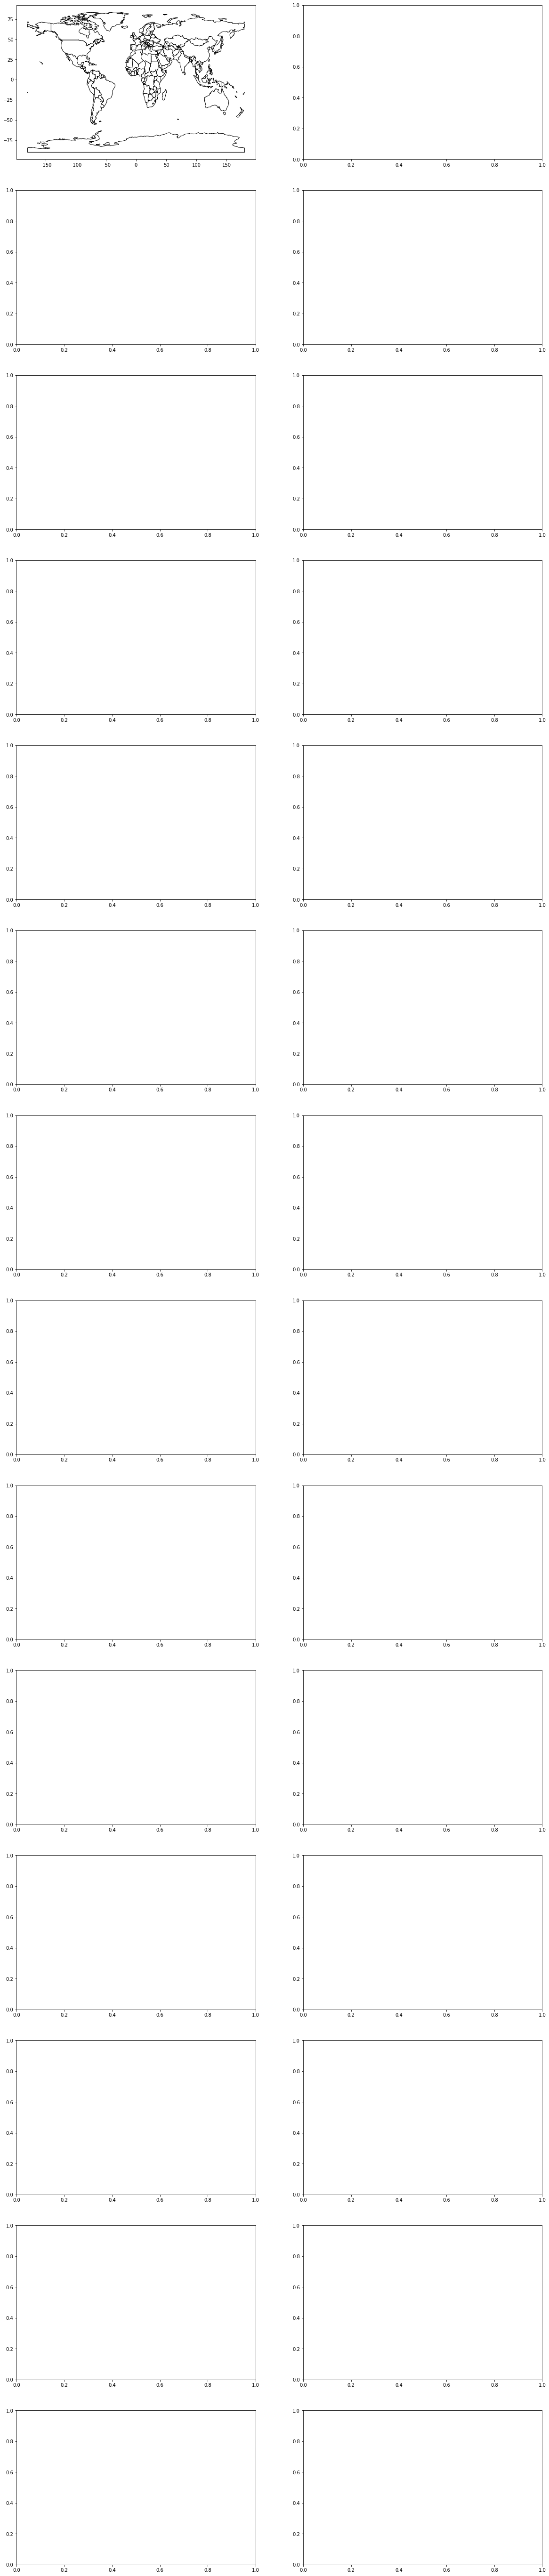

In [65]:
# gen maps for total displacement and gdp with events
gen_map_event_with_col(human_cost_gdf, conflict_gdf, column="total_displacement", name="map_event_deaths")
gen_map_event_with_col(human_cost_gdf, conflict_gdf, column="gdp", name="map_event_deaths")

In [ ]:
# Calculate data correlations
print("Total_displacement")
print("Pearson: ", stats.stats.pearsonr(human_cost_gdf["total_displacement"], human_cost_gdf["deaths"]))
print("Spearman: ", stats.stats.spearmanr(human_cost_gdf["total_displacement"], human_cost_gdf["deaths"]))
print("GDP")
print("Pearson: ", stats.stats.pearsonr(human_cost_gdf["gdp"], human_cost_gdf["deaths"]))
print("Spearman: ", stats.stats.spearmanr(human_cost_gdf["gdp"], human_cost_gdf["deaths"]))

### Plot by conflict instead of singular event

In [30]:
new_conflict_gdf = conflict_gdf[["year", "conflict_new_id", "best", "geometry" ]]
display(new_conflict_gdf.head(5))

,year,conflict_new_id,best,geometry
0,2010,230,2,POINT (44.206667 15.354722)
1,2011,715,0,POINT (45.036667 12.779444)
2,2011,230,0,POINT (46.141765 13.786202)
3,2012,230,5,POINT (46.141765 13.786202)
4,2012,230,5,POINT (45.3 15.616667)


In [31]:
dissolved_conflict_gdf = new_conflict_gdf.dissolve(by=["year", "conflict_new_id"], aggfunc='sum').reset_index()
display(dissolved_conflict_gdf.head(5))

,year,conflict_new_id,geometry,best
0,1989,209,"(POINT (120.3333 15.91667), POINT (120.466667 ...",822
1,1989,218,POINT (74.676 32.565),25
2,1989,220,POINT (-57.611111 -25.29389),150
3,1989,221,"(POINT (96.150408 16.79845), POINT (97.678028 ...",1000
4,1989,227,POINT (78.25117400000001 19.264791),7


In [32]:
new_geometry = dissolved_conflict_gdf["geometry"].apply(lambda x: x if type(x) is Point or len(x) < 3 else Polygon([(p.x, p.y) for p in x]))
dissolved_conflict_gdf.loc[:, "geometry"] = new_geometry
display(dissolved_conflict_gdf.head(5))

,year,conflict_new_id,geometry,best
0,1989,209,"POLYGON ((120.3333 15.91667, 120.466667 14.583...",822
1,1989,218,POINT (74.676 32.565),25
2,1989,220,POINT (-57.611111 -25.29389),150
3,1989,221,"POLYGON ((96.150408 16.79845, 97.678028 17.836...",1000
4,1989,227,POINT (78.25117400000001 19.264791),7


In [33]:
# gen maps for total displacement and gdp with conflicts
gen_map_event_with_col(human_cost_gdf, dissolved_conflict_gdf, column="total_displacement", name="map_conflict_deaths")
gen_map_event_with_col(human_cost_gdf, dissolved_conflict_gdf, column="gdp", name="map_conflict_deaths")

  0%|          | 0/28 [00:00<?, ?it/s]/home/lal/Programs/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log2
/home/lal/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/lal/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
 96%|█████████▋| 27/28 [00:55<00:02,  2.05s/it]/home/lal/Programs/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:702: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
100%|██████████| 28/28 [00:58<00:00,  2.09s/it]


## Create interactive event + metric maps with folium

### Use time slider

In [37]:
dt_index = pd.date_range(start=pd.datetime(1989, 1, 1), periods=28, freq='AS').strftime('%s')
year_to_dt_index_dict = {}
for year in range(len(dt_index)):
    year_to_dt_index_dict[year+1989] = dt_index[year]
display(dt_index)

array(['599612400', '631148400', '662684400', '694220400', '725842800',
       '757378800', '788914800', '820450800', '852073200', '883609200',
       '915145200', '946681200', '978303600', '1009839600', '1041375600',
       '1072911600', '1104534000', '1136070000', '1167606000',
       '1199142000', '1230764400', '1262300400', '1293836400',
       '1325372400', '1356994800', '1388530800', '1420066800', '1451602800'], 
      dtype='<U10')

In [38]:
# First we start with the chloropleth maps, its easier to manage
display(human_cost_gdf.head(1))

NameError: name 'human_cost_gdf' is not defined

In [36]:
def year_list_to_dt_index(year_list):
    indexes = np.subtract(year_list, 1989).astype(int)
    values = dt_index[indexes]
    return values

In [37]:
# We will use constant opacity and variable color to represent the metrics
def get_colormap(df, column="gdp"):
    min_value = df[column].min() 
    max_value = df[column].max() 
    cmap = linear.GnBu.scale(min_value, max_value)
    return cmap

cmap_gdp = get_colormap(human_cost_gdf, "gdp")
cmap_disp = get_colormap(human_cost_gdf, "total_displacement")
cmap_deaths = get_colormap(human_cost_gdf, "deaths")

In [38]:
display(human_cost_gdf.index.get_level_values(1))
human_cost_gdf.sort_index(inplace=True)

Float64Index([  2.0,  20.0,  31.0,  40.0,  41.0,  42.0,  51.0,  52.0,  70.0,
               80.0,
              ...
              816.0, 820.0, 840.0, 850.0, 860.0, 900.0, 910.0, 920.0, 940.0,
              950.0],
             dtype='float64', name='country_id', length=4444)

In [39]:
def get_style_data(df, column="gdp", opacity=0.7, ):
    cmap = get_colormap(df, column)
    style_data_dict = {}
    nbr_of_years = len(dt_index)
    min_color_value = "#ffffffff" 
    for country in df.index.get_level_values(1).unique():
        
        years = df.loc[(slice(None), country) , :].index.remove_unused_levels().get_level_values(0)
        
        partial_color_list = df.loc[(slice(None), country), column].apply(cmap).values
        partial_opacity_list = np.full(nbr_of_years, opacity)
        color_list = np.full(nbr_of_years, min_color_value)
        for index, year in enumerate(years):
            color_list[np.where(dt_index == year_to_dt_index_dict[year])] = partial_color_list[index]
        opacity_list = np.full(nbr_of_years, opacity)
        
        local_df = pd.DataFrame(
            {'color' : color_list,
             'opacity' : opacity_list},
             index=dt_index
        )
        local_df = local_df.sort_index()
        style_data_dict[str(int(country))] = local_df.to_dict(orient='index')
    return style_data_dict

In [40]:
only_country_gdf = human_cost_gdf.copy()
try:
    only_country_gdf.index = only_country_gdf.index.droplevel("year")
except: # If we rerun
    pass
only_country_gdf = only_country_gdf.iloc[~only_country_gdf.index.duplicated()].sort_index()
only_country_gdf = only_country_gdf.reset_index()
only_country_gdf["country_id"] = only_country_gdf["country_id"].astype(int)
only_country_gdf = only_country_gdf.set_index("country_id")
display(only_country_gdf.head(5))

,number_of_events,events_id,displacement_extern,displacement_intern,total_displacement,deaths,gdp,hdi,country_code,geometry
country_id,,,,,,,,,,
2,0.0,0,0.0,0.0,0.0,0.0,22599.992143,0.0,USA,"(POLYGON ((-155.54211 19.08348000000001, -155...."
20,0.0,0,0.0,0.0,0.0,0.0,20700.799311,0.0,CAN,(POLYGON ((-63.66449999999998 46.5500099999999...
31,0.0,0,0.0,0.0,0.0,0.0,14213.543372,0.0,BHS,(POLYGON ((-77.53465999999997 23.7597499999999...
40,0.0,[],7682.0,0.0,7682.0,0.0,2577.207019,0.0,CUB,POLYGON ((-82.26815121125706 23.18861074471771...
41,4.0,"[186087, 186122, 186123, 186124]",3344.0,0.0,3344.0,48.0,393.347528,0.0,HTI,POLYGON ((-73.18979061551762 19.91568390551191...


In [35]:
style_dict_gdp = get_style_data(human_cost_gdf, "gdp", 1.0)
print(len(style_dict_gdp))

NameError: name 'get_style_data' is not defined

In [42]:
only_country_gdf = only_country_gdf[["total_displacement", "deaths", "gdp", "geometry"]]
only_country_json = only_country_gdf.to_json() 
print(len(only_country_gdf))

161


In [43]:
m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=5)
slider_gdp = plugins.TimeSliderChoropleth(
    only_country_json,
    styledict = get_style_data(human_cost_gdf, "gdp", 0.7),
    name="gdp"
).add_to(m)
folium.LayerControl().add_to(m)
folium.plugins.Fullscreen().add_to(m)
m.save(os.path.join("results", "gdp_time_slider.html"))
m

This result is interesting, but the time slider is somewhat buggy and we can't add the event data to the timeline... we need to find another solution

### Use TimeStamped GeoJson

In [44]:
# Time stamped GeoJson makes it possible to use custom js for each event and for each country
# TODO:
# 4) Try to split them into different layers => didn't succeed yet

In [45]:
with open(os.path.join("pickle", 'distance_nx.pickle'), 'rb') as data_source:
    distance_graph = pickle.load(data_source)

In [77]:
conflict_graph_df = pd.DataFrame([])
for node in tqdm(distance_graph.nodes()):
    if distance_graph.node[node]["nature"] == "event":
        continue
    for year in distance_graph.node[node]["yearly_dict"]:
        conflict_graph_df = conflict_graph_df.append(distance_graph.node[node]["yearly_dict"][year],ignore_index=True)
display(conflict_graph_df.head(1))

100%|██████████| 136178/136178 [00:14<00:00, 9258.92it/s]   


,best,conflict_id,deaths_a,deaths_b,deaths_civilians,gwnoa,gwnob,latitude,longitude,side_a,side_b,type_of_violence,year
0,175.0,230.0,109.0,51.0,3.0,678.0,NaN,14.257709,45.931985,Government of Yemen (North Yemen),AQAP,1.0,2010.0


#### Get circle icons features for every events

In [47]:
def get_circle_icon_style_from_series(pd_series, opacity=0.7, color='green', radius_scale=1.0):
    """Get the icon_style to create circles with a radius influenced by the value
       TODO: add option to cmap the color field also
    """
    radius_array = list(pd_series.map(lambda val: radius_scale*np.log(val) if val != 0 else 0))
    icon_style_dict_array = []
    for index, val in tqdm(enumerate(radius_array)):
        icon_style_base_dict = {}
        icon_style_base_dict['fillColor'] = color
        icon_style_base_dict['fillOpacity'] = opacity
        icon_style_base_dict['opacity'] = 0
        local_dict = icon_style_base_dict
        local_dict['radius'] = np.asscalar(radius_array[index])
        icon_style_dict_array.append(local_dict)
    return icon_style_dict_array

In [48]:
def get_feature_circle_array(df, columns=["best", "deaths_civilians"], opacity =[0.5, 1], color=["red", "yellow"], radius_scale=[1.0, 1.0]):
    """Get the feature array for the circles. Each circles has its own params"""
    circle_style_array = []
    for index, column in tqdm(enumerate(columns)):
        circle_style_array.append(get_circle_icon_style_from_series(df[column], opacity=opacity[index], color=color[index], radius_scale=radius_scale[index]))
    # Create associated Features
    features = [[], []]
    for row in tqdm(df.itertuples()):
        for index in range(len(columns)):
            start = "{}-01-01".format(int(row.year))
            end = "{}-01-01".format(int(row.year)+1)
            local_marker_feature_dict = {
                                   "type": "Feature",
                                   "geometry": {"type": "Point",
                                                "coordinates": [row.longitude, row.latitude]
                                               },
                                   "properties" : {"time": "{}-01-01".format(int(row.year)),
                                                   "icon": "circle",
                                                   "iconstyle": circle_style_array[index][row.Index],
                                                   "id":"cir{}_{}".format(row.Index, index)
                                   }
            }
            features[index].append(local_marker_feature_dict)
    return features

In [49]:
feature_circle_array = get_feature_circle_array(
    conflict_graph_df,
    columns=["best", "deaths_civilians"],
    opacity =[0.9, 1],
    color=["red", "blue"],
    radius_scale=[1, 1]
    )

0it [00:00, ?it/s]
0it [00:00, ?it/s]
4865it [00:00, 720933.05it/s]
0it [00:00, ?it/s]
2it [00:00, 55.30it/s]09it/s]
4865it [00:00, 109449.30it/s]


#### Get popup marker icons features for every events

In [51]:
def extract_gnwo_countries_to_df():
    """Extract the countries from the gnwo and their id from the gnwo files"""
    countries_list = []
    # First gnwo file, contains id, code, name for all gnow numbers
    with open(os.path.join("data", "gnwo.txt"), "r") as gnow:
        for line in gnow:
            split_line = re.split(r'\t+', line)
            countries_list.append(split_line[0:3])
    countries =  pd.DataFrame(countries_list, columns=["id", "code" ,"name"])
    countries["id"] = pd.to_numeric(countries["id"])
    countries = countries.set_index("id")
    countries = countries.loc[~countries.index.duplicated()]
    return countries
countries = extract_gnwo_countries_to_df()

display(countries.head(1))

,code,name
id,,
2,USA,United States of America


In [52]:
def get_country_name(gwno):
    try:
        name = countries.loc[gwno, "name"]
    except:
        name = "N/A"
    return name

In [61]:
def get_popup_icon_style_from_conflict_type(pd_series, size=5):
    """Really basic function to get the icon style from the type of series, could be more complex""" 
    BASE_MARKER_NAME="free-map-marker-icon-"
    icon_style_dict_array = []
    for index, value in enumerate(pd_series):
        # Add more values as needed
        icon_style_base_dict = {}
        icon_style_base_dict['iconSize'] = [size, size]
        local_dict = icon_style_base_dict
        if value == 1:
            color = 'blue'
        elif value == 2:
            color = 'orange'
        elif value == 3:
            color = 'pink'
        #local_dict['iconColor'] = color
        icon_name = BASE_MARKER_NAME+color+".png"
        local_dict['iconUrl'] = os.path.join("../data", "icons", icon_name)#"http://besticons.net/sites/default/files/chat-exclamation-icon-8614.png"
        local_dict['iconOpacity'] = 0.8
        local_dict['iconAnchor'] = (size//2,size)
        icon_style_dict_array.append(local_dict)
    return icon_style_dict_array

In [69]:
base_popup_table_str = """
        <h3>Conflict Id: {}<h3>
        <h4>Conflict Type: {}<h4>
        <table style=\"width:100%\">
          <tr>
            <th>Side </th>
            <th>Actor Name</th> 
            <th>Country</th>
          </tr>
          <tr>
            <td>A</td>
            <td>{}</td> 
            <td>{}</td>
          </tr>
          <tr>
            <td>B</td>
            <td>{}</td> 
            <td>{}</td>
          </tr>
        </table>
        <table style=\"width:100%\">
          <tr>
            <th>Actor</th>
            <th>Deaths</th> 
          </tr>
          <tr>
            <td>Side A</td>
            <td>{}</td> 
          </tr>
          <tr>
            <td>Side B</td>
            <td>{}</td> 
          </tr>
          <tr>
            <td>Civilians</td>
            <td>{}</td> 
          </tr>
          <tr>
            <td>Total</td>
            <td>{}</td> 
          </tr
        </table>
    """

In [70]:
conflict_type_from_nbr = {
    1:"State Based",
    2:"Non State",
    3:"One Sided",
}

In [71]:
def get_feature_marker_array(df):
    """This function uses the extracted features to create the feature dictionnary"""
    marker_style_array = get_popup_icon_style_from_conflict_type(df.type_of_violence, size=20)
    features = []
    for row in tqdm(df.itertuples()):
        if row.best is 0:
            continue
        local_marker_feature_dict = {
           "type": "Feature",
           "geometry": {"type": "Point",
                        "coordinates": [row.longitude, row.latitude]
                       },
           "properties" : {"time": "{}-01-01".format(int(row.year)),
                           #"popup": "<h1>{}</h1>".format(np.asscalar(row.conflict_id)),
                           "popup": base_popup_table_str.format(np.asscalar(row.conflict_id),
                                          conflict_type_from_nbr[row.type_of_violence],
                                          row.side_a,
                                          get_country_name(row.gwnoa),
                                          row.side_b,
                                          get_country_name(row.gwnob),
                                          np.asscalar(row.deaths_a),
                                          np.asscalar(row.deaths_b),
                                          np.asscalar(row.deaths_civilians),
                                          np.asscalar(row.best)
                                    ),
                           "icon": "marker",
                           "iconstyle": marker_style_array[row.Index],
                           "id":"marker_{}".format(np.asscalar(row.Index))

           }
        }
        features.append(local_marker_feature_dict)
    return features
        

In [72]:
feature_marker_array = get_feature_marker_array(conflict_graph_df)

4865it [00:00, 6062.79it/s]


#### Create feature for the various countries metrics

In [176]:
local_human_cost_gdf = human_cost_gdf.reset_index()
display(local_human_cost_gdf.head(1))

,year,country_id,number_of_events,events_id,displacement_extern,displacement_intern,total_displacement,deaths,gdp,hdi,country_code,geometry
0,1989.0,2.0,0.0,0,0.0,0.0,0.0,0.0,22599.992143,0.0,USA,"(POLYGON ((-155.54211 19.08348000000001, -155...."


In [194]:
print(list(colormap._schemes.keys()))

['BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'BrBg', 'PiYG', 'PRGn', 'PuOr', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3']


In [184]:
def get_colormap(df, column, cmap_value="YlGn", linear=True, bins = 10, method='quantles'):
    cmap = colormap.LinearColormap(colors = colormap._schemes[cmap_value],
                                   vmin=df[column].min(),
                                   vmax=df[column].max(),
                                   caption=column.upper()) 
    if linear:
        return cmap
    else:
        return cmap.to_step(data = list(df[column]), n= bins, method=method)

In [185]:
def get_feature_choropleth_array(df, cmap, column="gdp", border_color="black", border_weight=1, fill_opacity=0.8):
    min_color_value = "#ffffffff"
    
    feature_choropleth_array = []
    for row in df.itertuples():
        properties_dict = {}
        col_val = df.loc[row.Index, column]
        
        fill_color = min_color_value if col_val == df[column].min() \
                                else cmap(col_val)
        # Get time / time array
        base_time = "{}-01-01".format(int(row.year))
        if type(row.geometry) is shapely.geometry.multipolygon.MultiPolygon: 
            time =[ base_time for item in range(len(row.geometry))]
            properties_dict["times"] = time
        else:
            time = base_time
            properties_dict["time"] = time
        properties_dict["id"] = "{}_{}".format(column, np.asscalar(row.Index))
        local_style_dict = { "color": border_color,
                             "weight":border_weight,
                             "fillColor": fill_color,
                             "fillOpacity": fill_opacity,
                            }
        properties_dict["style"] = local_style_dict
        
        local_feature_dict = {
           "type": "Feature",
           "geometry": shapely.geometry.mapping(row.geometry),
           "properties": properties_dict
           }
        feature_choropleth_array.append(local_feature_dict)
    return feature_choropleth_array
        

In [179]:
#choropleth_column = "gdp"
#cmap_value = "YlGn" 
#cmap_feature_choropleth = get_colormap(local_human_cost_gdf, choropleth_column, cmap_value) 
#feature_choropleth_array = get_feature_choropleth_array(local_human_cost_gdf,
#                                                        cmap = cmap_feature_choropleth,
#                                                        column = choropleth_column,
#                                                       )

#### Create Map

In [180]:
local_human_cost_gdf.head(1)

,year,country_id,number_of_events,events_id,displacement_extern,displacement_intern,total_displacement,deaths,gdp,hdi,country_code,geometry
0,1989.0,2.0,0.0,0,0.0,0.0,0.0,0.0,22599.992143,0.0,USA,"(POLYGON ((-155.54211 19.08348000000001, -155...."


In [181]:
def fix_map_hack_fct(conflict_map_name):
    # HACK: We do this because of the limitations of the Folium library
    # NOTE: need to add: duration: period in the html script of the TimestampedGeoJson plugin
    #                       at the line 147, in geoJson Layer instanciation
    # First hack to have good refresh
    replace_period = '"P11M"'
    with fileinput.FileInput(os.path.join('results', conflict_map_name), inplace=True) as f:
        TEXT_TO_SEARCH = "updateTimeDimension: "
        TEXT_TO_REPLACE = "duration: {}, {}".format(replace_period, TEXT_TO_SEARCH)
        for line in f:
            print(line.replace(TEXT_TO_SEARCH, TEXT_TO_REPLACE), end='')

    # Second hack to remove multiple occurences of the TimeDimension Control
    with fileinput.FileInput(os.path.join('results', conflict_map_name), inplace=True) as f:      
        counter = 0
        TEXT_TO_SEARCH = "L.Control.TimeDimensionCustom = L.Control.TimeDimension.extend"
        for line_nbr, line in enumerate(f):
            if line_nbr < 128: # End of first map layer
                print(line, end='')
            # Skip lines starting from the TimeDimensionCustom
            elif TEXT_TO_SEARCH in line:
                print("//{}".format(line),end='')
                counter += 1
                continue
            elif 0 < counter < 22:
                print("//{}".format(line),end='')
                counter += 1
            else:
                counter = 0
                print(line,end='')

In [221]:
def create_map(choropleth_column=None, cmap_value="YlGr", linear=True):
    m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=5)

    # Get features
    feature_circle_array = get_feature_circle_array(
        conflict_graph_df,
        columns=["best", "deaths_civilians"],
        opacity =[0.98, 1],
        color=["blue", "pink"],
        radius_scale=[1, 1]
        )

    total_deaths_circle = plugins.TimestampedGeoJson(
        {
            'type': 'FeatureCollection',
            'features': feature_circle_array[0]
        },
        period='P1Y',
        add_last_point=False,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY',
        time_slider_drag_update=True,
    )
    m.add_child(total_deaths_circle, name="Total Deaths")

    civilian_deaths_circle = plugins.TimestampedGeoJson(
        {
            'type': 'FeatureCollection',
            'features': feature_circle_array[1]
        },
        period='P1Y',
        add_last_point=False,
        auto_play=False,
        loop=False,
        max_speed=10,
        loop_button=True,
        date_options='YYYY',
        time_slider_drag_update=True,
    )
    m.add_child(civilian_deaths_circle, name="Civilian Deaths")

    # Get popup
    feature_marker_array = get_feature_marker_array(conflict_graph_df)
    popup_markers = plugins.TimestampedGeoJson(
        {
            'type': 'FeatureCollection',
            'features': feature_marker_array 
        },
        period='P1Y',
        add_last_point=False,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY',
        time_slider_drag_update=True,
    )
    m.add_child(popup_markers, name="Conflict Markers")

    # Get choropleth
    if choropleth_column: # Only generate if we setted a value for choropleth column
        cmap_value = cmap_value 
        cmap_feature_choropleth = get_colormap(local_human_cost_gdf,
                                               choropleth_column,
                                               cmap_value,
                                               linear=linear,
                                               bins = 20,
                                               method='quantile'
                                              ) 
        feature_choropleth_array = get_feature_choropleth_array(local_human_cost_gdf,
                                                                cmap = cmap_feature_choropleth,
                                                                column = choropleth_column,
                                                                fill_opacity=0.7
                                                           )
        choropleth_gdp = plugins.TimestampedGeoJson(
            {
                'type': 'FeatureCollection',
                'features': feature_choropleth_array
            },
            period='P1Y',
            add_last_point=False,
            auto_play=False,
            loop=False,
            max_speed=1,
            loop_button=True,
            date_options='YYYY',
            time_slider_drag_update=True,
        )
        m.add_child(choropleth_gdp, name="Choropleth")
        cmap_feature_choropleth.add_to(m)
        conflict_map_name = "map_conflict_feature_geojson_{}.html".format(choropleth_column)
    else:
        conflict_map_name = "map_conflict_feature_geojson.html"

    folium.LayerControl().add_to(m)

    m.save(os.path.join('results', conflict_map_name))
    
    # HACK to fix the output
    fix_map_hack_fct(conflict_map_name)

In [222]:
print(list(colormap._schemes.keys()))

['BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'BrBg', 'PiYG', 'PRGn', 'PuOr', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3']


In [223]:
for column in [None, "gdp", "hdi", "total_displacement"]:
    print("Creating map for {}".format(column), flush=True)
    #linear = False if column is "total_displacement" else True
    linear=True
    cmap_dict = { None: None,
                  "gdp": "YlOrBr",
                  "hdi": "BrBg",
                  "total_displacement": "YlOrBr"
    }
    create_map(column, cmap_value=cmap_dict[column], linear=linear) 

Creating map for None


0it [00:00, ?it/s]
0it [00:00, ?it/s]
4865it [00:00, 755192.04it/s]
0it [00:00, ?it/s]
2it [00:00, 67.51it/s]55it/s]
4865it [00:00, 115035.85it/s]
4865it [00:00, 7513.34it/s]


Creating map for gdp


0it [00:00, ?it/s]
0it [00:00, ?it/s]
4865it [00:00, 449534.92it/s]
0it [00:00, ?it/s]
2it [00:00, 47.07it/s]19it/s]
4865it [00:00, 87346.55it/s]
4865it [00:00, 7486.62it/s]


Creating map for hdi


0it [00:00, ?it/s]
0it [00:00, ?it/s]
4865it [00:00, 594317.26it/s]
0it [00:00, ?it/s]
2it [00:00, 53.59it/s]44it/s]
4865it [00:00, 110974.30it/s]
4865it [00:00, 7343.05it/s]


Creating map for total_displacement


0it [00:00, ?it/s]
0it [00:00, ?it/s]
4865it [00:00, 687162.45it/s]
0it [00:00, ?it/s]
2it [00:00, 56.29it/s]35it/s]
4865it [00:00, 89028.31it/s]
4865it [00:00, 6839.04it/s]
